In [11]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import MetaTrader5 as mt5
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis

In [12]:
list_tickers = ['EWJ', 'EWT', 'EWY', 'EWZ', 'EZU', 'INDA', 'ITOT', 'MCHI']
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2020, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame(
            pd.to_datetime(max(database, key=len)['time'], unit='s'),
            columns=['time']
        )
    for ticker, col in zip(list_tickers, database):
        df[ticker] = pd.DataFrame(col['close'])
    df = df.set_index('time', drop=True)
    data = df.dropna().pct_change().dropna()

In [13]:
def MV_criterion(weights, data):
    """
    Ountput:
        optimización del criterio de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        data(type ndarray numpy): Retornos de los activos
    """
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25/100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    # Calcular el criterio
    criterion = (Wbar**(1-Lambda)/(1+Lambda)+
                 Wbar**(-Lambda)*W*mean-
                 Lambda/2*Wbar**(-1-Lambda)*
                 W**2*std**2
                 )
    criterion = -criterion
    return criterion

In [14]:
def SK_criterion(weights, data):
    """
    Ountput:
        optimización del criterio de la cartera
    Inputs:
        weights(type ndarray numpy): Pesos de la cartera
        data(type ndarray numpy): Retornos de los activos
    """
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media, la volatilidad, el sesgo y la curtosis de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    skewness = skew(portfolio_return, 0)
    kurt = kurtosis(portfolio_return, 0)
    # Calcular el criterio
    criterion = Wbar**(1 - Lambda) / (1 + Lambda) + Wbar**(-Lambda)\
        * W * mean - Lambda / 2 * Wbar**(-1 - Lambda) * W**2 * std**2\
        + Lambda * (Lambda + 1) / (6) * Wbar**(-2 - Lambda) * W**3 * skewness\
        - Lambda * (Lambda + 1) * (Lambda + 2) / (24) * Wbar**(-3 - Lambda)\
        * W**4 * kurt
    criterion = -criterion
    return criterion

In [15]:
split = int(0.7*len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]
# Encontrar el número de activos
n = data.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución del problema de optimización
res_MV = minimize(SK_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
# Resultado
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 330.8647220890299
            Iterations: 14
            Function evaluations: 135
            Gradient evaluations: 14


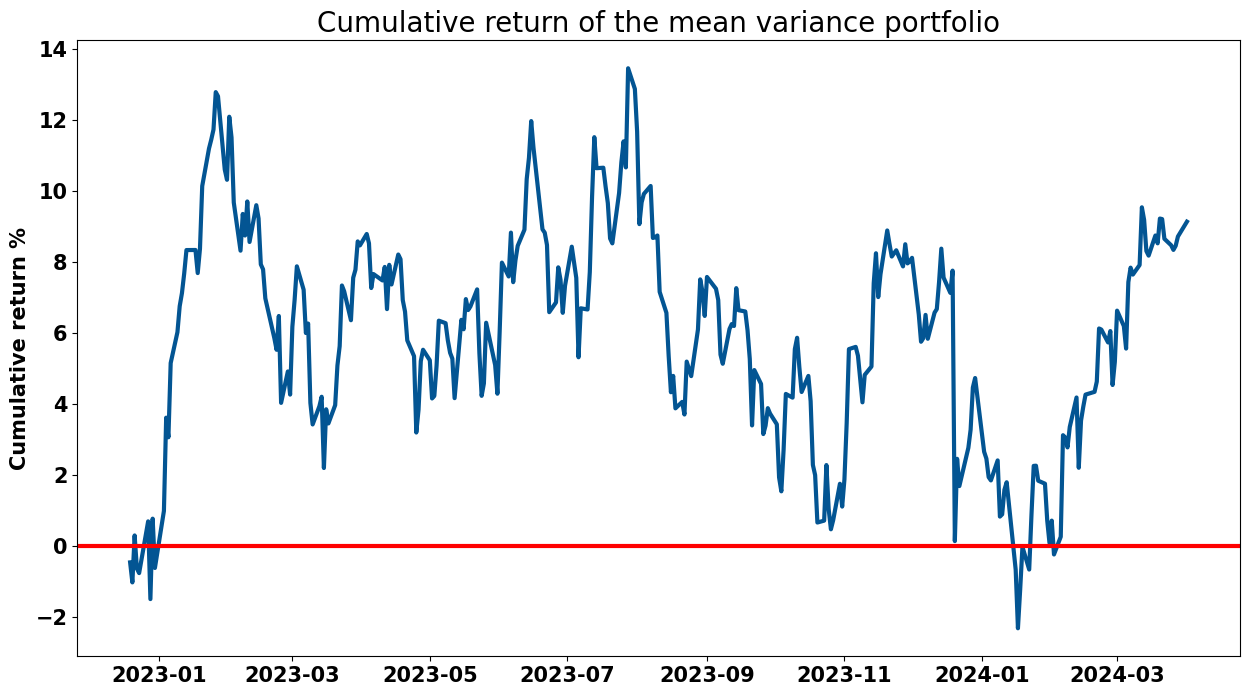

In [16]:
# Calcular la retabilidad acumulada de la cartera
portfolio_return_MV = np.multiply(test_set, np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)
# Representar el CM
plt.figure(figsize = (15, 8))
plt.plot(np.cumsum(
            portfolio_return_MV)*100,
            color='#035593',
            linewidth=3
         )
plt.ylabel("Cumulative return %",
           size=15,
           fontweight='bold')
plt.xticks(size=15,
           fontweight='bold'
           )
plt.yticks(size=15,
           fontweight='bold'
           )
plt.title("Cumulative return of the mean variance portfolio",
          size=20)
plt.axhline(0, 
            color='r',
            linewidth=3
            )
plt.show()

In [17]:
pd.DataFrame(X_MV*100, columns=['Pesos'], index=df.columns)

,Pesos
EWJ,1.876913e+01
EWT,4.266379e+01
EWY,0.000000e+00
EWZ,0.000000e+00
EZU,0.000000e+00
INDA,0.000000e+00
ITOT,4.082333e-08
MCHI,3.856709e+01
